# Model the density of the "accreted/unevolved" stellar halo selected in the Magnamal plane in APOGEE DR17

In [ ]:
import os
import sys

os.environ['DUST_DIR'] = '/Users/dhortadarrington/Packages/mwdust/'

import numpy as np
import matplotlib.pyplot as plt
import utils
import densprofiles
from galpy.util import coords
import mwdust
import tqdm
import emcee
import dill as pickle
import multiprocessing
import scipy.optimize as op
from scipy import interpolate
from sklearn.mixture import GaussianMixture
from isodist import FEH2Z, Z2FEH
import corner
import safe_colours
import astropy.io.fits as fits

safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging')

columnwidth = 240./72.27
textwidth = 504.0/72.27

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

os.environ['RESULTS_VERS'] = 'dr17'
os.environ['SDSS_LOCAL_SAS_MIRROR'] = '/Users/dhortadarrington/Documents/Projects/halo-density/data/'
os.environ['ISODIST_DATA'] = '/Users/dhortadarrington/Packages/isodist/'


In [ ]:
os.environ["PATH"]='/opt/homebrew/bin:/opt/homebrew/sbin:/Users/dhortadarrington/opt/\
    anaconda3/bin:/Users/dhortadarrington/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'


In [ ]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

In [ ]:
mask = np.load('../sav/mask_parent.npy', allow_pickle=True)
mask_une = np.load('../sav/mask_unevolved.npy', allow_pickle=True)
print(len(data[mask]), len(data[mask&mask_une]))

In [ ]:
# lowfehbins = np.array([-3.,-1.6])
# lowafebins = np.array([0.,0.2,0.4])
ebins = [0.,0.7,1.]
ndistmods=301
minmax_distmods=[6.,18.] # from 0.1 to 40 kpc
nthreads = int(multiprocessing.cpu_count()//2)
isorec = utils.generate_lowfeh_isogrid()
dmap = mwdust.Combined19()
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)

force = False
if os.path.exists('../sav/apogeeCombinedSF_DR17.dat') and not force:
    with open('../sav/apogeeCombinedSF_DR17.dat', 'rb') as f:
        apo = pickle.load(f)

if os.path.exists('../essf/effsel_grid_dr17-protoMW.dat') and not force:
    with open('../essf/effsel_grid_dr17-protoMW-2024.dat', 'rb') as f:
        outarea = pickle.load(f)


In [ ]:
Indx = mask&mask_une

In [7]:
X, Y, Z = data['X']*8.275, data['Y']*8.275, data['Z']*8.275

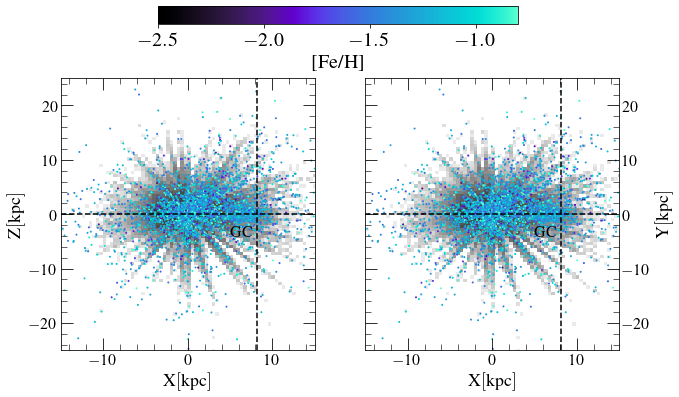

In [8]:
import cmasher as cm
from matplotlib.colors import LogNorm

#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2,figsize=(10,5))
# fig.set_size_inches(textwidth,columnwidth)
plt.rc('font',family='serif',size=14)
# mask = (allstar_f['FE_H'] < -1.) & good_datamask & (allstar_f['C_FE'] < 0.15) &  (allstar_f['N_FE'] >= 0.5) & (allstar_f['FE_H'] > -3.)  & (allstar_f['LOGG'] < 3.) & (allstar_f['LOGG'] > 1.)
ax[0].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[0].scatter(XYZ[:,0][goodindx],XYZ[:,2][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
color = ax[0].scatter(X[Indx],Y[Indx], c=data['FE_H'][Indx], s=1, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.8)
ax[0].axvline(8.178, c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
# ax[0].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[0].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[0].set_ylim(-25,25)
ax[0].set_xlim(-15,15)
# ax[0].legend(loc='lower left',frameon=False)
ax[1].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[1].scatter(XYZ[:,0][goodindx],XYZ[:,1][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
ax[1].scatter(X[Indx],Y[Indx], c=data['FE_H'][Indx], s=1, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.8)
# ax[1].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[1].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[1].axvline(8.178, c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-25,25)
ax[1].set_xlim(-15,15)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[0].set_ylabel(r'$\mathrm{Z} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_ylabel(r'$\mathrm{Y} \mathrm{[kpc]}$', fontsize=18)
ax[0].text(5.,-4,r'GC', fontsize=16)
ax[1].text(5.,-4,r'GC', fontsize=16)
ax[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12)
ax[0].tick_params(which='minor', length=6, direction='in',top=True,right=True)
ax[0].minorticks_on()
ax[1].tick_params(which='major',labelsize=16,direction='in',top=True, left=True,right=True,length=12)
ax[1].tick_params(which='minor', length=6, direction='in',top=True, left=True,right=True)
ax[1].minorticks_on()
# plt.savefig('../plots/spatial2.pdf', format='pdf', dpi=400, bbox_inches='tight')

cbar_ax = fig.add_axes([0.26, 1.03, 0.5,0.05])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
# cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
cbar.set_label(label=r'[Fe/H]',fontsize=20)
cbar.ax.tick_params(labelsize=20)

# plt.savefig('../plots/spatial_new.png', format='png', dpi=400, bbox_inches='tight',rasterized=True)


In [9]:
rads = np.sqrt(X**2 + Z**2)

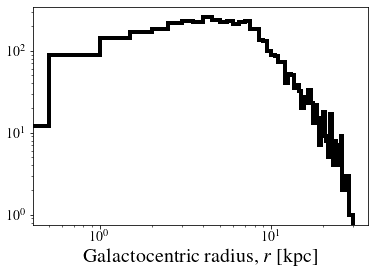

In [10]:
plt.hist(rads[mask&mask_une], np.linspace(0,30,61), histtype='step',color='k', lw=4)
plt.xlabel('Galactocentric radius, $r$ [kpc]', fontsize=20)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.1,31)
plt.show()


In [11]:
rapo = np.load('../sav/rapo_gala.npy', allow_pickle=True)
print(len(rapo))

4531


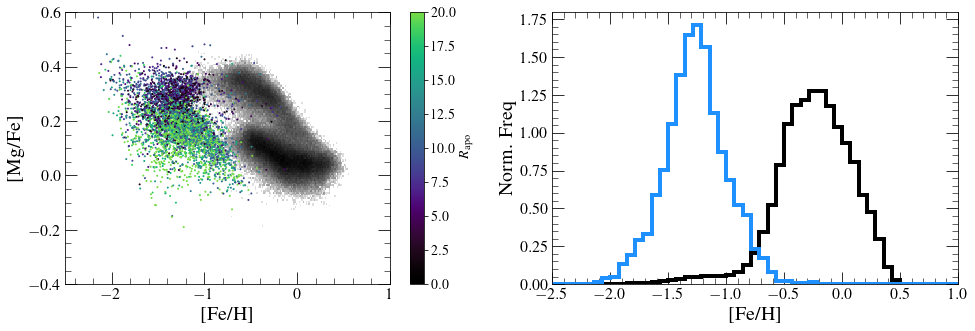

In [12]:
plt.figure(figsize=(16,5), facecolor='white')

plt.subplot(1,2,1)
mask_plot = (data['FE_H']>-10) & (data['MG_FE']>-10)
plt.hist2d(data['FE_H'][mask&mask_plot], data['MG_FE'][mask&mask_plot], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['FE_H'][Indx], data['MG_FE'][Indx], c=rapo,s=1, cmap=cm.lavender, vmin=0,vmax=20)
plt.xlabel('[Fe/H]', fontsize=20)
plt.ylabel('[Mg/Fe]', fontsize=20)
plt.colorbar(label='$R_{\mathrm{apo}}$')
plt.xlim(-2.5,1)
plt.ylim(-0.4,0.6)
plt.tick_params(which='major',labelsize=16,direction='in',top=True, left=True,right=True,length=12)
plt.tick_params(which='minor', length=6, direction='in',top=True, left=True,right=True)
plt.minorticks_on()

plt.subplot(1,2,2)
plt.hist(data['FE_H'][mask&(data['FE_H']>-10)],bins=np.linspace(-2.5,1,50), histtype='step', lw=4, color='k', density=True)
plt.hist(data['FE_H'][Indx],bins=np.linspace(-2.5,1,50), histtype='step', lw=4, color='dodgerblue', density=True)
plt.xlim(-2.5,1)
plt.xlabel('[Fe/H]', fontsize=20)
plt.ylabel('Norm. Freq', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True, left=True,right=True,length=12)
plt.tick_params(which='minor', length=6, direction='in',top=True, left=True,right=True)
plt.minorticks_on()


# Slice the magnamal ``unevolved'' stars in the Tinsley diagram and fit a profile that is an einasto with a parameter that has contamination from a halo like GES, taking the best fit params from Ted's paper

In [13]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# remove fields in the bulge direction
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])
# bulgeindx = ((aposel_glons > 355) | (aposel_glons < 5)) & (np.fabs(aposel_glats) < 5)
# goodindx = goodfields & ~bulgeindx & (apo._locations != 5093) #remove bad fields
goodindx_eff = goodfields & (apo._locations != 5093) #remove bad fields
goodlocs = apo._locations[goodindx_eff]
# remove data not in the final field list
good_datamask = [data['LOCATION_ID'][i] in goodlocs for i in tqdm.tqdm_notebook(range(len(data)))]
# good_datamask *= data['weighted_dist']/data['weighted_dist_error'] > 5.


  0%|          | 0/733900 [00:00<?, ?it/s]

In [14]:
#these functions are necessary to do the fits to the APOGEE giants. They could be in with the utils, but for simplicity, I just put them here!
from scipy import integrate

#first need to get the minimum J-K in each field
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])
jkmaxs = np.array([apo.JKmax(apo._locations[i]) for i in range(len(apo._locations))])

def calc_bic_loglike(mask, params, fehrange=[-2.5,-0.5], effsel=outarea, model = densprofiles.spherical):
    loglike = utils.loglike(params,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask])
    print((sum(mask)))
    bic = sum(params)*np.log(sum(mask))-2*loglike
    return bic, loglike
    
def fit_bin_mask(mask, fehrange=[-2.5,-0.5], effsel=outarea, model=densprofiles.spherical, just_MLE=True, just_MCMC=False, mass=False, init= [2.], ncut=100, analytic=False, inttype='spherical'):
    '''
    Fits the stars defined by a mask to the APOGEE low metallicity sample
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    fehrange - the range in Fe/H spanned by the sample defined by mask
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    just_MLE - do the Maximum Likelihood and return opt
    just_MCMC - do the MCMC
    mass - also compute the total mass
    init - initial input parameters for the density model
    ncut - number of samples to cut from each MCMC chain
    analytic - compute the mass integral analytically (only works for spherical density models)
    inttype - the coordinate scheme for the integration grid for mass computation
    OUTPUT:
    opt - opt from op.minimize
    samples - MCMC samples
    masses - MC samples of mass
    facs - the normalisation factor corresponding to each mass sample
    '''
    #needs goodindx_eff defined above. 'mask' must be same length as gaia2_matches[omask].
    print(sum(mask))
    if not just_MCMC:
        # do MLE. 
        mloglike = lambda x: utils.mloglike(x,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask])
        print(mloglike)
        opt = op.fmin(lambda x: utils.mloglike(x,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask]), init, full_output=True)
        print(opt[0])
        if just_MLE:
            return opt
    # do MCMC initialised from best result from MLE or from init params given
    ndim, nwalkers = len(init), 100
    if just_MCMC:
        pos = [init + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    else:
        pos = [opt[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    nit = 1000
    threads = 4
    #only effsel for good fields
    effsel_in = effsel[goodindx_eff]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
    #re-build Rphiz grid
    Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff]
    #set up sampler and do the sampling.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                        args=(model, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0][mask], Rphiz[:,1][mask], Rphiz[:,2][mask]), 
                                        threads=threads,moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DEMove(), 0.2)])
    for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
        continue
    #cut ncut samples from each chain
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    if not mass:
        if just_MCMC:
            return samples
        else:
            return opt, samples, sampler
        
    isofactors = np.zeros(len(effsel[goodindx_eff]))
    for i in tqdm.tqdm_notebook(range(len(isofactors))):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx_eff][i]) & (isorec['logg'] > 0.5) & (isorec['logg'] < 3.5) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 4000.) & (10**(isorec['logTe']) < 5500.)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx_eff][i], maxjk=jkmaxs[goodindx_eff][i])
        isofactors[i] = avmass/massratio #fraction of stellar mass in giants
        #set up grid for integration
        rthetaphigrid = np.mgrid[0.1:40.:150j,0:np.pi:150j,0:2*np.pi:150j]
        dr = (40.-0.1)/149
        dtheta = (np.pi-0.)/149
        dphi = (2*np.pi-0.)/149
        shape = np.shape(rthetaphigrid.T)
        rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
        deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
        x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
        y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
        z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
        xyzgrid = np.dstack([x,y,z])[0]
        rphizgrid = coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
        rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    if model is densprofiles.broken_pw or model is densprofiles.triple_pw or model is densprofiles.spl_pw or model is densprofiles.einasto or model is densprofiles.einasto_rot or model is densprofiles.broken_pw_nodisc or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk or model is densprofiles.einasto_expdisc or model is densprofiles.einasto_geshalo:
        masses = np.zeros((400,3))
    facs = np.zeros(400)
    for ii,params in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 400, replace=False)]), total=400):
        rate = model(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params)*effsel[goodindx_eff]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
        sumrate = np.sum(rate.T/isofactors) #conversion factor between RGB number counts and total stellar mass
        norm = sum(mask)/sumrate
        fac = norm*(180./np.pi)**2  #conversion factor between RGB number counts and total stellar mass accounted for density normalisation
        if analytic:
            #only for spherical power law!
            rsun = np.sqrt(8.178**2+0.02**2)
            min_r = 0.1
            max_r = 25.
            alpha = params[0]
            integral = 4*np.pi*((rsun**alpha*max_r**(3-alpha))/(3-alpha)-(rsun**alpha*min_r**(3-alpha))/(3-alpha))
            masses[ii] = integral*fac
        else:
#             if model is densprofiles.broken_pw or model is densprofiles.triple_pw or model is densprofiles.spl_pw or model is densprofiles.einasto or model is densprofiles.einasto_simple or model is densprofiles.einasto_rot or model is densprofiles.broken_pw_nodisc or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
            denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
            halodens = denstxyz[0]*fac
            diskdens = denstxyz[1]*fac
            fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
            masses[ii] = np.sum(fulldens*deltafactor), np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor)

        facs[ii] = fac
    if just_MCMC:
        return samples, masses, facs
    return opt, samples,sampler, masses, facs


In [15]:
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)

import cmasher as cm
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(dat):
    l, b, d = dat['GLON'], dat['GLAT'], dat['weighted_dist']/1e3
    XYZ = coords.lbd_to_XYZ(l,b,d, degree=True)
    Rphiz = coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8.178, Zsun=0.02)
    return XYZ, Rphiz
XYZ, Rphiz = allstar_to_coords(data)

In [16]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params))*effsel[goodindx_eff]*ds**3
    
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

In [17]:
Rgrid.shape

(1965, 301)

# First fit all the unevolved stars together

In [18]:
Indx = mask&mask_une
print(len(data[Indx]))

4531


In [23]:
opt_ein_disc = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto_expdisc, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 0.], full_output=True)
ein_disc_pd, ein_disc_pdt, ein_disc_rate = pdistmod_model(densprofiles.einasto_expdisc,opt_ein_disc[0], outarea, returnrate=True)


In [24]:
opt_ein_disc

(array([5.93062996e+01, 2.27113692e+10, 4.49333982e-01]),
 41564.12985116117,
 347,
 600,
 1)

In [25]:
opt_ein = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5.], full_output=True)
ein_pd, ein_pdt, ein_rate = pdistmod_model(densprofiles.einasto,opt_ein[0], outarea, returnrate=True)


In [26]:
opt_ein

(array([7.41927534e+01, 2.19119107e+10]), 41596.68981606807, 220, 400, 1)

In [ ]:
opt_tri = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)
tri_pd, tri_pdt, tri_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_tri[0], outarea, returnrate=True)


In [ ]:
opt_ein_halo = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto_geshalo, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 0.], full_output=True)
ein_halo_pd, ein_halo_pdt, ein_halo_rate = pdistmod_model(densprofiles.einasto_geshalo,opt_ein_halo[0], outarea, returnrate=True)


In [ ]:
opt_expdisc = op.fmin(lambda x: utils.mloglike(x,densprofiles.justexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [1/1.8,1/0.8], full_output=True)
expdisc_pd, expdisc_pdt, expdisc_rate = pdistmod_model(densprofiles.justexpdisk,opt_expdisc[0], outarea, returnrate=True)


In [ ]:
opt_spl = op.fmin(lambda x: utils.mloglike(x,densprofiles.spl_pw, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,0.5,0.5,0.,0.,0.,0.1], full_output=True)
spl_pd, spl_pdt, spl_rate = pdistmod_model(densprofiles.spl_pw,opt_spl[0], outarea, returnrate=True)


In [ ]:
opt_spl

In [ ]:
opt_spl_simple = op.fmin(lambda x: utils.mloglike(x, densprofiles.spherical, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx], Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.], full_output=True)
spl_simple_pd, spl_simple_pdt, spl_simple_rate = pdistmod_model(densprofiles.spherical,opt_spl_simple[0], outarea, returnrate=True)


In [ ]:
opt_axi = op.fmin(lambda x: utils.mloglike(x, densprofiles.axisymmetric, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx], Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,3.], full_output=True)
axi_pd, axi_pdt, axi_rate = pdistmod_model(densprofiles.axisymmetric,opt_axi[0], outarea, returnrate=True)


In [ ]:
opt_ein_disc_cutoff = op.fmin(lambda x: utils.mloglike(x, densprofiles.einasto_expdisc_cutoff, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx], Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,3., 1.,0.], full_output=True)
ein_disc_cutoff_pd, ein_disc_cutoff_pdt, ein_disc_cutoff_rate = pdistmod_model(densprofiles.einasto_expdisc_cutoff,opt_ein_disc_cutoff[0], outarea, returnrate=True)


In [ ]:
opt_broken = op.fmin(lambda x: utils.mloglike(x,densprofiles.broken_pw_nodisc, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,3.,5.,0.5,0.5,0.,0.,0.], full_output=True)
broken_pd, broken_pdt, broken_rate = pdistmod_model(densprofiles.broken_pw_nodisc,opt_broken[0], outarea, returnrate=True)


In [ ]:
plt.figure(figsize=(8,5), facecolor='white')

data_distmod= 5*np.log10(data['weighted_dist'][Indx]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,ein_disc_pd,lw=3., color='r', label='Einasto + disc')
# plt.plot(distmods,ein_pd,lw=3., color='lime', label='Einasto')
# plt.plot(distmods, tri_pd,lw=3., color='b', label='Full Triaxial SPL')
# plt.plot(distmods, spl_pd,lw=3., color='dodgerblue', label='SPL')
# plt.plot(distmods,ein_halo_pd,lw=3., color='darkorchid', label='Einasto + GES halo')
# plt.plot(distmods,expdisc_pd,lw=3., color='orchid', label='Exp Disc')
# plt.plot(distmods,broken_pd,lw=3., color='orange', label='Full Broken PL')
# plt.plot(distmods,spl_simple_pd,lw=3., color='brown', label='Spherical PL')
# plt.plot(distmods,axi_pd,lw=3., color='lavender', label='Axisymmetric PL')
# plt.plot(distmods,ein_disc_cutoff_pd,lw=3., color='g', label='Einasto + disc + cutoff')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

In [ ]:
plt.figure(figsize=(8,5), facecolor='white')

data_distmod= 5*np.log10(data['weighted_dist'][Indx]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,ein_disc_pd,lw=3., color='r', label='Einasto + disc')
plt.plot(distmods,ein_pd,lw=3., color='lime', label='Einasto')
plt.plot(distmods, tri_pd,lw=3., color='b', label='Full Triaxial SPL')
plt.plot(distmods,ein_halo_pd,lw=3., color='darkorchid', label='Einasto + GES halo')
# plt.plot(distmods,expdisc_pd,lw=3., color='orchid', label='Exp Disc')
# plt.plot(distmods,broken_pd,lw=3., color='orange', label='Full Broken PL')
plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)

In [ ]:
def get_cdf(data, bins):
        
    count, bins_count = np.histogram(data, bins=bins) 
    pdf = count/sum(count)
    return np.cumsum(pdf)

In [ ]:
cdf_data = get_cdf(data_distmod, np.linspace(distmods[0],distmods[-1],25))

In [ ]:
plt.plot(np.linspace(distmods[0],distmods[-1],24),cdf_data, color='k', label='Data', lw=4)
plt.plot(distmods, np.cumsum(ein_disc_pd)/sum(ein_disc_pd),lw=3., color='r', label='Einasto + disc')
plt.plot(distmods,np.cumsum(ein_pd)/sum(ein_pd),lw=3., color='lime', label='Einasto')
plt.plot(distmods, np.cumsum(tri_pd)/sum(tri_pd),lw=3., color='b', label='Full Triaxial SPL')
plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'CDF($x$)',fontsize=16)
# plt.yscale('log')
plt.xlim(8,17)
plt.ylim()

We see that the triaxial or Einasto+triaxial profiles are the ones that fit the distribution best, closely followed by the Einasto profile alone. Let's fit these models to the data with MCMC

In [ ]:
# Indices = mask&mask_une&(~np.isnan(Rphiz[:,2]))

# opt_ein_halo, samples_ein_halo, sampler_ein_halo, masses_ein_halo, facs_ein_halo = fit_bin_mask(Indices, fehrange=[-2.5,-0.5], effsel=outarea, model=densprofiles.einasto_geshalo, just_MLE=False, just_MCMC=False, mass=True, init= opt_ein_halo[0], ncut=100, analytic=False)


In [ ]:
np.save('../sav/opt_ein_halo', opt_ein_halo[0])
np.save('../sav/samples_ein_halo', samples_ein_halo)
np.save('../sav/sampler_ein_halo', sampler_ein_halo)
np.save('../sav/masses_ein_halo', masses_ein_halo)
np.save('../sav/facs_ein_halo', facs_ein_halo)


In [ ]:
dn = 3.*opt_ein_halo[0][0] - 0.3333 + 0.0079/opt_ein_halo[0][0]

rs = np.linspace(0.1,25,128)

alpha_ein = -(dn/opt_ein_halo[0][0]) * (rs/opt_ein_halo[0][1])**(1/opt_ein_halo[0][0])

In [ ]:

plt.plot(rs,alpha_ein)
plt.ylabel(r'$\alpha_{\mathrm{Ein}}$', fontsize=20)

In [ ]:
Indices = mask&mask_une&(~np.isnan(Rphiz[:,2]))

opt_ein, samples_ein, sampler_ein, masses_ein, facs_ein = fit_bin_mask(Indices, fehrange=[-2.5,-0.5], effsel=outarea, model=densprofiles.einasto, just_MLE=False, just_MCMC=False, mass=True, init= opt_ein[0], ncut=100, analytic=False)


In [ ]:
np.save('../sav/opt_ein', opt_ein[0])
np.save('../sav/samples_ein', samples_ein)
np.save('../sav/sampler_ein', sampler_ein)
np.save('../sav/masses_ein', masses_ein)
np.save('../sav/facs_ein', facs_ein)


In [30]:
Indices = mask&mask_une&(~np.isnan(Rphiz[:,2]))

opt_ein_disc, samples_ein_disc, sampler_ein_disc, masses_ein_disc, facs_ein_disc = fit_bin_mask(Indices, fehrange=[-2.5,-0.5], effsel=outarea, model=densprofiles.einasto_expdisc, just_MLE=False, just_MCMC=False, mass=True, init= opt_ein_disc[0], ncut=100, analytic=False)


4531
<function fit_bin_mask.<locals>.<lambda> at 0x60cbc69d0>
[9.99927785e+01 1.29890893e+17 4.52797351e-01]


  0%|          | 0/1000 [00:00<?, ?it/s]

emcee: Exception while calling your likelihood function:
  params: [9.94933222e+01 1.29890893e+17 5.27489268e-01]
  args: (<function einasto_expdisc at 0x1574d5dc0>, array([[5.16672057e-07, 6.03620476e-07, 6.94936300e-07, ...,
        4.00360837e-02, 3.70804776e-02, 3.31549507e-02],
       [2.13553899e-06, 2.60322709e-06, 3.10535949e-06, ...,
        3.61129148e-01, 3.81647606e-01, 4.03331873e-01],
       [4.34769550e-08, 5.09603524e-08, 5.82611979e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.35575772e-07, 6.36280744e-07, 7.20076083e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.06484919e-07, 4.74313367e-07, 5.45556248e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.06364469e-07, 4.56069461e-07, 5.07878409e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), array([[ 8.17955963,  8.17961714,  8.17967678, ..., 38.87014804,
        39.56103811, 40.26532695],
       [ 8.3

Traceback (most recent call last):
  File "/Users/dhortadarrington/opt/anaconda3/lib/python3.9/site-packages/emcee-3.1.3.dev4+g37dc02e-py3.9.egg/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/dhortadarrington/Documents/Projects/halo-density/py/utils.py", line 386, in loglike
    logeffvol = np.log(effvol(densfunc,effsel,Rgrid,phigrid,zgrid,params=params))
  File "/Users/dhortadarrington/Documents/Projects/halo-density/py/utils.py", line 375, in effvol
    effdens = tdens(densfunc,Rgrid,phigrid,zgrid,params=params)
  File "/Users/dhortadarrington/Documents/Projects/halo-density/py/utils.py", line 364, in tdens
    dens = densfunc(Rgrid,phigrid,zgrid,params=params)
  File "/Users/dhortadarrington/Documents/Projects/halo-density/py/densprofiles.py", line 175, in einasto_expdisc
    dens = np.exp(-dn*((r_all/reb)**(1./n)-1))
KeyboardInterrupt


KeyboardInterrupt: 

In [29]:
samples_ein_disc

NameError: name 'samples_ein_disc' is not defined

In [ ]:
np.save('../sav/opt_ein_expdisc', opt_ein_disc[0])
np.save('../sav/samples_ein_expdisc', samples_ein_disc)
np.save('../sav/sampler_ein_expdisc', sampler_ein_disc)
np.save('../sav/masses_ein_expdisc', masses_ein_disc)
np.save('../sav/facs_ein_expdisc', facs_ein_disc)


In [ ]:
Indices = mask&mask_une&(~np.isnan(Rphiz[:,2]))

opt_spl_triaxial_full, samples_spl_triaxial_full,sampler_spl_triaxial_full, masses_spl_triaxial_full, facs_spl_triaxial_full = fit_bin_mask(Indices, fehrange=[-2.5,-0.5], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= opt_tri[0], ncut=100, analytic=False)


In [ ]:
np.save('../sav/opt_spl_triaxial_full', opt_spl_triaxial_full[0])
np.save('../sav/samples_spl_triaxial_full', samples_spl_triaxial_full)
np.save('../sav/sampler_spl_triaxial_full', sampler_spl_triaxial_full)
np.save('../sav/masses_spl_triaxial_full', masses_spl_triaxial_full)
np.save('../sav/facs_spl_triaxial_full', facs_spl_triaxial_full)


In [ ]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params))*effsel[goodindx_eff]*ds**3
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

def check_fit(mask, samp, effsel, model, distmods, sample=False):
    print(sum(mask))
    
    pds = np.empty((200,len(distmods)))
    if sample:
        for ii,params in tqdm.tqdm_notebook(enumerate(samp[np.random.randint(len(samp), size=200)]), total=200):
            pd, pdt,rate = pdistmod_model(model, params, effsel, returnrate=True)
            pds[ii] = pd
        return pds
    else:
        pd, pdt, rate = pdistmod_model(model, np.median(samp,axis=0), effsel, returnrate=True)
        return pd

# pd_tri = check_fit(Indx, samples_spl_triaxial_full, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
# pd_ein = check_fit(Indx, samples_ein, outarea, densprofiles.einasto, distmods, sample=True)
# pd_ein_halo = check_fit(Indx, samples_ein_halo, outarea, densprofiles.einasto_geshalo, distmods, sample=True)
pd_ein_disc = check_fit(Indx, samples_ein_disc, outarea, densprofiles.einasto_expdisc, distmods, sample=True)



# labels = [r'$\alpha_{\mathrm{in}}$', r'$\alpha_{\mathrm{out}}$', r'R$_{\mathrm{break}}$',\
#          r'$p$',r'$q$',r'$\gamma$',r'$\beta$',r'$\delta$',r'$f_{\mathrm{disk}}$']
# labels = [r'$n$',r'$r_{\mathrm{eff}}$',r'$f_{\mahrm{disc}}']

# fig = corner.corner(samples_ein_disc, show_titles=True, quantiles=[0.16,0.5,0.84], title_kwargs={"fontsize": 25},label_kwargs={"fontsize": 25},tick_kwargs={"fontsize": 20},titlepad=0.3)#fontsize=36)
# fig = corner.corner(samples_ein_disc)#fontsize=36)
# plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
# plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
# plt.minorticks_on()


for ax in fig.get_axes():
    ax.tick_params(axis='both',labelsize=10)
# from matplotlib import rcParams

# rcParams["font.size"] = 12
# rcParams["axes.labelpad"] = 7


ax = fig.add_axes([.7,.6,0.45,0.45])
axes = fig.get_axes()[0]

plt.figure(facecolor='white')

data_distmod= 5*np.log10(data['weighted_dist'][Indx])-5
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=56, color='k', histtype='step',lw=4., alpha=0.7 , label='APOGEE DR17')

plt.plot(distmods,np.nanpercentile(pd_ein_disc,50,axis=0),lw=2., color='r', label=r'Einasto plus exp disc')
plt.fill_between(distmods,np.nanpercentile(pd_ein_disc,5,axis=0),np.nanpercentile(pd_ein_disc,95,axis=0), color='r', alpha=0.35)

# plt.plot(distmods,np.nanpercentile(pd_ein_halo,50,axis=0),lw=2., color='darkorchid', label=r'Einasto + GES halo')
# plt.fill_between(distmods,np.nanpercentile(pd_ein_halo,5,axis=0),np.nanpercentile(pd_ein_halo,95,axis=0), color='darkorchid', alpha=0.35)

# plt.plot(distmods,np.nanpercentile(pd_tri,50,axis=0),lw=2., color='lime', label=r'Triaxial SPL')
# plt.fill_between(distmods,np.nanpercentile(pd_tri,5,axis=0),np.nanpercentile(pd_tri,95,axis=0), color='lime', alpha=0.35)

plt.xlim(8,18)
plt.legend(frameon=False, loc=2,fontsize=20)
plt.xlabel(r'distance modulus, $\mu$',fontsize=25)
plt.ylabel(r'$f(\mu)$',fontsize=25)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# axes.tick_params(labelsize=16)

# fig.set_size_inches(1.6*textwidth,1.6*textwidth)

# plt.savefig('/Users/dhortadarrington/Documents/Projects/halo-density/plots/broken-withdisc-noapocut.pdf',dpi=500,fmt='pdf', bbox_inches = 'tight')



In [ ]:
fig = plt.figure(figsize=(15,5), facecolor='white')

# # plt.subplot(1,2,1)
# plt.hist2d(samples_ein[:,0], samples_ein[:,1], bins=50, norm=LogNorm())
# plt.xlim(np.nanmedian(samples_ein[:,0]) - 5 * np.nanstd(samples_ein[:,0]), np.nanmedian(samples_ein[:,0]) + 5 * np.nanstd(samples_ein[:,0]))
# plt.ylim(np.nanmedian(samples_ein[:,1]) - 5 * np.nanstd(samples_ein[:,1]), np.nanmedian(samples_ein[:,1]) + 5 * np.nanstd(samples_ein[:,1]))
# plt.xlabel('$n$', fontsize=30)
# plt.ylabel('$r_{\mathrm{break}}$', fontsize=30)

# # plt.subplot(1,2,2)
# # plt.hist2d(samples_ein[:,0], samples_ein[:,2], bins=50, norm=LogNorm())
# # plt.xlim(np.nanmedian(samples_ein[:,0]) - 5 * np.nanstd(samples_ein[:,0]), np.nanmedian(samples_ein[:,0]) + 5 * np.nanstd(samples_ein[:,0]))
# # plt.ylim(np.nanmedian(samples_ein[:,2]) - 5 * np.nanstd(samples_ein[:,2]), np.nanmedian(samples_ein[:,2]) + 5 * np.nanstd(samples_ein[:,2]))
# # plt.xlabel('$n$', fontsize=30)
# # plt.ylabel('$f_{\mathrm{disc}}$', fontsize=30)

plt.subplot(1,3,3)
plt.hist2d(samples_ein_disc[:,1], samples_ein_disc[:,2], bins=50, norm=LogNorm())
plt.xlim(np.nanmedian(samples_ein_disc[:,1]) - 5 * np.nanstd(samples_ein_disc[:,1]), np.nanmedian(samples_ein_disc[:,1]) + 5 * np.nanstd(samples_ein_disc[:,1]))
plt.ylim(np.nanmedian(samples_ein_disc[:,2]) - 5 * np.nanstd(samples_ein_disc[:,2]), np.nanmedian(samples_ein_disc[:,2]) + 5 * np.nanstd(samples_ein_disc[:,2]))
plt.xlabel('$r_{\mathrm{break}}$', fontsize=30)
plt.ylabel('$f_{\mathrm{disc}}$', fontsize=30)

plt.show()

In [ ]:
from scipy import integrate
def calc_masses(model, facs, samples):
    rthetaphigrid = np.mgrid[0.1:25:150j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (25-0.1)/149
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    deltafactor = rthetaphigrid[0]**2*np.sin(rthetaphigrid[1])*dtheta*dphi #here the rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1]) is the Jacobian
    x = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.cos(rthetaphigrid[2])
    y = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.sin(rthetaphigrid[2])
    z = rthetaphigrid[0]*np.cos(rthetaphigrid[1])
    rphizgrid = coords.rect_to_cyl(x, y, z)
    halomasses = np.empty((300,150))
    for ii,param in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 300, replace=False)])):
        if model is densprofiles.spherical:
            r = np.linspace(0.1,25,150)
            for jj,rs in enumerate(r):
                rsun = np.sqrt(8.**2+0.02**2)
                alpha = param[0]
                max_r = 25.
                min_r = 0.1
                r = np.linspace(0.1,25,150)
                integral = 4*np.pi*rsun**alpha*((max_r**(3-alpha))/(3-alpha)-((min_r+rs)**(3-alpha))/(3-alpha))
                masses[ii,jj] = integral*facs[ii]
        elif model is densprofiles.einasto_simple or densprofiles.einasto_rot:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param)
            halogriddens = dens*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
        else:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param,split=True)
            halogriddens = dens[0]*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
    return halomasses

In [ ]:
protomwmass = calc_masses(densprofiles.einasto, facs_ein, samples_ein)

protomwmass.shape

In [ ]:
# calculate the mass in 25kpc from halo 
print('Within 25kpc')
mass = np.nansum(protomwmass,axis=1)*(25-0.1)/149
print(np.nanpercentile(mass,[16,50,84]))
# calculate the mass in 6kpc from halo
print('Within 6 kpc')
mass = np.nansum(protomwmass[:,:36],axis=1)*(25-0.1)/149
print(np.nanpercentile(mass,[16,50,84]))


# Now split the sample into the chemical cells and run the density modelling again

In [31]:
c1 = np.load('../sav/mask_c1.npy',allow_pickle=True)
c2 = np.load('../sav/mask_c2.npy',allow_pickle=True)
c3 = np.load('../sav/mask_c3.npy',allow_pickle=True)
c4 = np.load('../sav/mask_c4.npy',allow_pickle=True)
c5 = np.load('../sav/mask_c5.npy',allow_pickle=True)
c6 = np.load('../sav/mask_c6.npy',allow_pickle=True)
c7 = np.load('../sav/mask_c7.npy',allow_pickle=True)
c8 = np.load('../sav/mask_c8.npy',allow_pickle=True)
c9 = np.load('../sav/mask_c9.npy',allow_pickle=True)

In [32]:
masks_c = [c1, c2, c3, c4, c5, c6, c7, c8, c9]

In [44]:
def fit_cells(densprofile, masks, init_params = [2.,5.]):
    
    opt_cells = []
    pd_cells = []
    pdt_cells = []
    rate_cells = [] 

    for indx, i in tqdm.tqdm_notebook(enumerate(masks)):
        opt = op.fmin(lambda x: utils.mloglike(x,densprofile, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][i],Rphiz[:,1][i], Rphiz[:,2][i]), init_params, full_output=True)
        pd, pdt, rate = pdistmod_model(densprofile,opt[0], outarea, returnrate=True)
        
        opt_cells.append(opt[0])
        pd_cells.append(pd) 
        pdt_cells.append(pdt) 
        rate_cells.append(rate)                      
                                       
    return np.array(opt_cells), np.array(pd_cells), np.array(pdt_cells), np.array(rate_cells)


In [45]:
opt_ein_cells, pd_ein_cells, pdt_ein_cells, rate_ein_cells = fit_cells(densprofiles.einasto, masks_c, init_params = [2.,5.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2921.591727
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 7574.147512
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 422.320326
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 4581.303311
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 1027.546169
         Iterations: 98
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 1561.699194
         Iterations: 168
         Function evaluations: 336


In [35]:
opt_ein_cells

array([[1.63876939e+00, 5.99264529e+00],
       [2.53240123e+00, 3.83833023e+00],
       [3.50900566e+00, 2.82912428e+00],
       [6.79486777e+01, 4.53265413e+13],
       [5.27588749e+01, 5.25513641e+12],
       [3.27580148e+00, 3.03905169e+01],
       [7.68695842e-02, 1.64912297e+01],
       [4.22645780e-02, 3.77659839e+01],
       [9.73524745e+00, 5.56362557e+04]])

In [46]:
opt_ein_halo_cells, pd_ein_halo_cells, pdt_ein_halo_cells, rate_ein_halo_cells = fit_cells(densprofiles.einasto_geshalo, masks_c, init_params = [2.,5.,0.])


0it [00:00, ?it/s]

In [47]:
opt_ein_halo_cells

array([[2., 5., 0.],
       [2., 5., 0.],
       [2., 5., 0.],
       [2., 5., 0.],
       [2., 5., 0.],
       [2., 5., 0.],
       [2., 5., 0.],
       [2., 5., 0.],
       [2., 5., 0.]])

In [48]:
opt_tri_cells, pd_tri_cells, pdt_tri_cells, rate_tri_cells = fit_cells(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, masks_c, init_params = [2.,1.,0.5,0.5,0.,0.,0.,0.01])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 7478.619991
         Iterations: 952
         Function evaluations: 1407
Optimization terminated successfully.
         Current function value: 414.082377
         Iterations: 338
         Function evaluations: 570
Optimization terminated successfully.
         Current function value: 4587.092022
         Iterations: 987
         Function evaluations: 1557
Optimization terminated successfully.
         Current function value: 278.408729
         Iterations: 316
         Function evaluations: 567
Optimization terminated successfully.
         Current function value: 1033.904492
         Iterations: 744
         Function evaluations: 1271
Optimization terminated successfully.
         Current function value: 1562.653945
         Iterations: 908
         Function evaluations: 1455


In [49]:
opt_tri_cells

array([[1.54913450e+00, 1.91249978e-01, 8.43045399e-01, 7.05104991e-01,
        2.91777481e-07, 1.98797256e-03, 7.16685658e-04, 6.55000698e-10],
       [2.15229024e+00, 1.92081725e-01, 8.43460005e-01, 5.94053690e-01,
        3.11222806e-02, 1.35690252e-02, 6.85652157e-03, 3.67909558e-02],
       [2.24768512e+00, 2.20263565e-01, 6.86701729e-01, 4.15294228e-01,
        1.25673833e-10, 6.70254165e-04, 4.08182360e-09, 1.18349481e-02],
       [1.79210763e+00, 1.38437672e-02, 9.98773972e-01, 9.99991353e-01,
        3.95872024e-03, 3.40118135e-05, 4.68318373e-03, 2.25753183e-03],
       [1.68681854e+00, 1.00072198e-02, 9.99778969e-01, 9.99999701e-01,
        3.43875298e-03, 7.51203101e-04, 2.81374671e-03, 2.26484725e-03],
       [1.72092396e+00, 1.46473630e-02, 8.57563924e-01, 6.67775594e-01,
        4.57771463e-03, 2.23707382e-03, 7.54844526e-11, 3.68973868e-03],
       [2.76163224e-05, 1.00005336e-02, 7.77603354e-01, 5.95725409e-01,
        1.93010503e-03, 7.85003768e-04, 2.66236588e-03, 5.

In [50]:
opt_ein_disc_cells, pd_ein_disc_cells, pdt_ein_disc_cells, rate_ein_disc_cells = fit_cells(densprofiles.einasto_expdisc, masks_c, init_params = [2.,5.,0.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2920.793706
         Iterations: 128
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 7544.112767
         Iterations: 206
         Function evaluations: 359
Optimization terminated successfully.
         Current function value: 410.240214
         Iterations: 183
         Function evaluations: 324
Optimization terminated successfully.
         Current function value: 4581.285619
         Iterations: 144
         Function evaluations: 259
Optimization terminated successfully.
         Current function value: 1022.888423
         Iterations: 163
         Function evaluations: 328


In [51]:
opt_ein_disc_cells

array([[1.51584383e+00, 6.31738447e+00, 3.18630030e-01],
       [2.94353017e+00, 4.30558139e+00, 7.46556735e-01],
       [8.34813464e+00, 1.46816460e+00, 9.49305461e-01],
       [4.19373493e+01, 2.02754583e+10, 3.29256839e-01],
       [3.15970905e+01, 1.91909875e+09, 3.00750840e-01],
       [3.08109363e+00, 2.89186953e+01, 4.71168071e-02],
       [7.71976495e-02, 2.01087734e+01, 4.33477440e-01],
       [1.25479568e-01, 2.11437258e+03, 5.65932097e-01],
       [9.73486394e+00, 5.56072048e+04, 1.54255195e-07]])

In [52]:
opt_expdisc_cells, pd_expdisc_cells, pdt_expdisc_cells, rate_expdisc_cells = fit_cells(densprofiles.justexpdisk, masks_c, init_params = [1/1.8,1/0.8])


0it [00:00, ?it/s]

In [53]:
opt_expdisc_cells

array([[0.55555556, 1.25      ],
       [0.55555556, 1.25      ],
       [0.55555556, 1.25      ],
       [0.55555556, 1.25      ],
       [0.55555556, 1.25      ],
       [0.55555556, 1.25      ],
       [0.55555556, 1.25      ],
       [0.55555556, 1.25      ],
       [0.55555556, 1.25      ]])

In [54]:
np.round(opt_ein_disc_cells[:,0],3)


array([ 1.516,  2.944,  8.348, 41.937, 31.597,  3.081,  0.077,  0.125,
        9.735])

In [55]:
np.round(opt_ein_disc_cells[:,1],3)

array([6.31700000e+00, 4.30600000e+00, 1.46800000e+00, 2.02754583e+10,
       1.91909875e+09, 2.89190000e+01, 2.01090000e+01, 2.11437300e+03,
       5.56072050e+04])

In [56]:
np.round(opt_ein_disc_cells[:,2],3)

array([0.319, 0.747, 0.949, 0.329, 0.301, 0.047, 0.433, 0.566, 0.   ])

In [ ]:
dn = 3.*opt_ein_disc_cells[1,0] - 0.3333 + 0.0079/opt_ein_disc_cells[1,0]

rs = np.linspace(0.1,25,128)

alpha_ein = -(dn/opt_ein_disc_cells[1,0]) * (rs/opt_ein_disc_cells[1,1])**(1/opt_ein_disc_cells[1,0])
plt.plot(rs,alpha_ein)
plt.ylabel(r'$\alpha_{\mathrm{Ein}}$', fontsize=20)
plt.vlines(8.2,-8,0)


In [ ]:
opt_tri_cells[:,0]

Text(0.5, 0, 'Distance moduli')

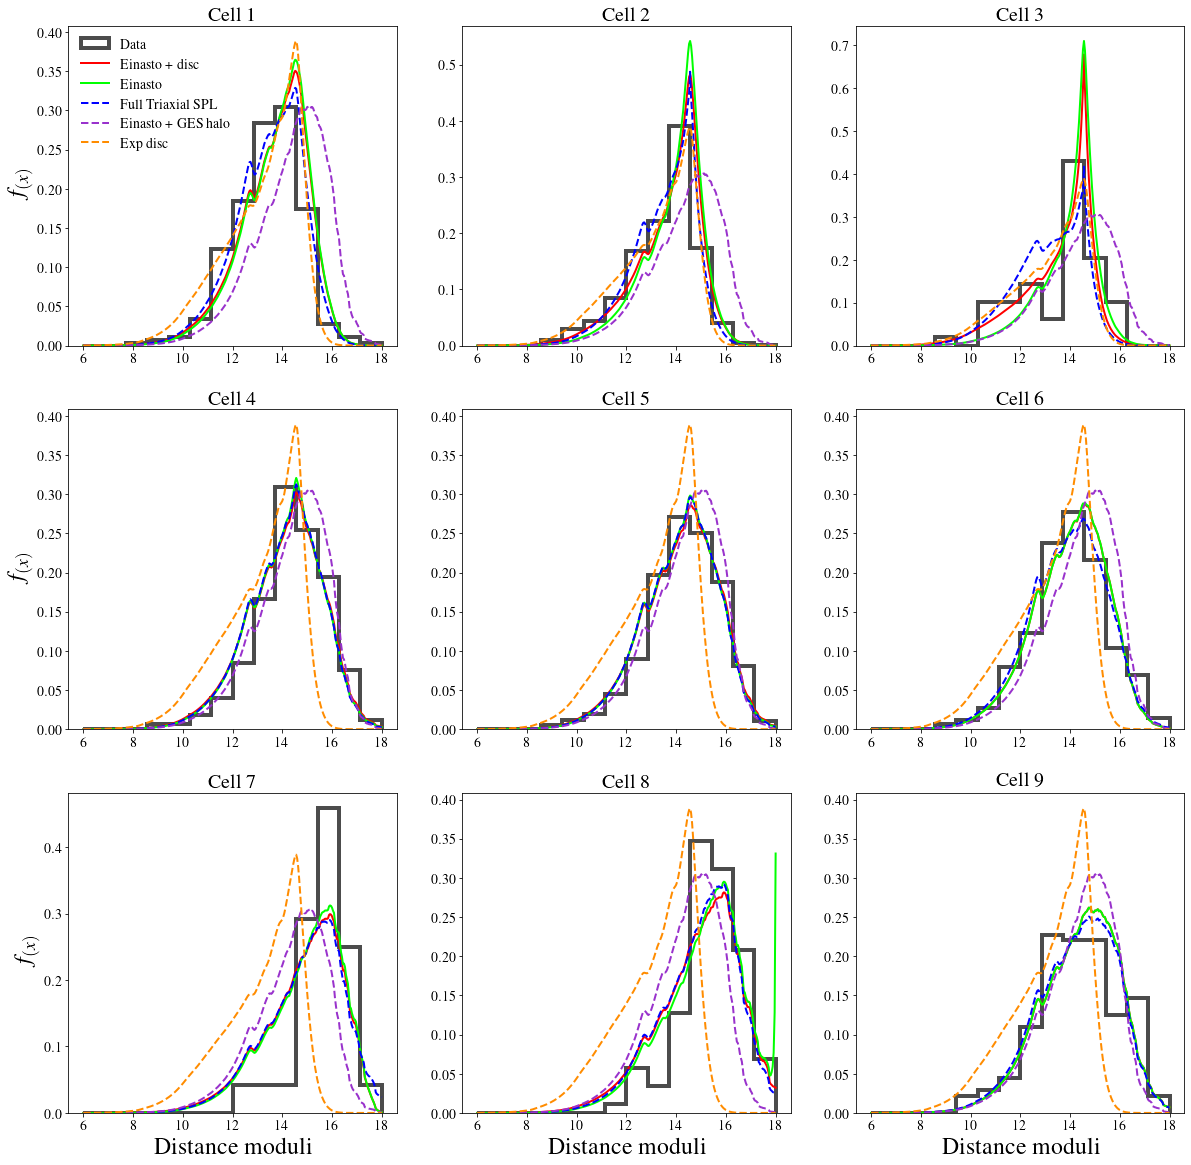

In [57]:
plt.figure(figsize=(20,20), facecolor='white')

plt.subplot(3,3,1)
i = 0
plt.title('Cell 1', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,2)
i = 1
plt.title('Cell 2', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,3)
i = 2
plt.title('Cell 3', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,4)
i = 3
plt.title('Cell 4', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,5)
i = 4
plt.title('Cell 5', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,6)
i = 5
plt.title('Cell 6', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,7)
i = 6
plt.title('Cell 7', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,8)
i = 7
plt.title('Cell 8', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)


plt.subplot(3,3,9)
i = 8
plt.title('Cell 9', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)


In [ ]:
plt.figure(figsize=(20,20), facecolor='white')

plt.subplot(3,3,1)
i = 0
plt.title('Cell 1', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,2)
i = 1
plt.title('Cell 2', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,3)
i = 2
plt.title('Cell 3', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,4)
i = 3
plt.title('Cell 4', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,5)
i = 4
plt.title('Cell 5', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,6)
i = 5
plt.title('Cell 6', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,7)
i = 6
plt.title('Cell 7', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=24)

plt.subplot(3,3,8)
i = 7
plt.title('Cell 8', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)


plt.subplot(3,3,9)
i = 8
plt.title('Cell 9', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc', ls='--')
# plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)


In [ ]:
i = 3
plt.title('Cell 4', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[i],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=24)


In [ ]:
plt.title('Cell 5', fontsize=20)
i = 4
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[i],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='r', label='Einasto + disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
plt.plot(distmods, pd_tri_cells[i],lw=2., color='b', label='Full Triaxial SPL', ls='--')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo', ls='--')
# plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=24)